# Systeme de recommendation avec scikit learn

In [16]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import ipywidgets as widgets
from IPython.display import display

In [17]:
#permet de supprimer les caractères spéciaux
def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

#permet de transformer le titre saisie ainsi que les tous les titres de notre base de données en vecteur
#puis calcul la similarité entre le titre saisie et les autres titres de la bd pour retourner 
#ceux qui sont le plus semblables à ce qui est saisie 
def search_engine(title):
    title = clean_title(title)
    vector_fit = vectorizer.transform([title])
    similarity = cosine_similarity(vector, vector_fit).flatten()
    index = np.argpartition(similarity, -5)[-7:]
    results = movies.iloc[index][::-1]
    return results


#permet de récuper les films les plus similaires au film qui à été passez en paramètre
def get_similar(movie_name,rating,corrMatrix):
    #à partir du nom du film passé en paramètre on peut récuperer le film et les valeurs des corrélation par rapport aux autres films 
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    #on classe par odre décroissant les corrélations
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

#permet de faire la saisie et de récupérer la valeur saisie dans le champs
def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        result=search_engine(title)
        display(result)

#permet de faire une série d'opérations pour retourner les films les plus similaire à ce qu'on veut
def correlations(ratings,input_movie,input_rate):
    similar_movies = pd.DataFrame()
    #on fait un pivot en mettant les utilisateur en index en column les films et en valeur les rating
    userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
    #on supprime les valeurs qui ont moins de 10 votes et on transform les NAN en 0
    userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
    #on calcul la matrice de correlation avec la similarité de pearson
    corrMatrix = userRatings.corr(method='pearson')
    #une fois qu'on a la matrice de correlation il sufffit de transmettre le nom du film qu'on veut noter ainsi que sa note 
    similar_movies = get_similar(input_movie,input_rate,corrMatrix)
    #similar_movies=similar_movies.sum().sort_values(ascending=False).head(7)
    return similar_movies

In [18]:
#lecteur des données qui vont constituer la bd
ratings = pd.read_csv('dataset/ratings.csv')
movies = pd.read_csv('dataset/movies.csv')

#suppression des caractères spéciaux
movies["clean_title"] = movies["title"].apply(clean_title)

#permet de fusionner les films et les votes en supprimant les tables dont on a besoin
ratings = pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)

#permet de transformer les films en vector pour faciler le calcul de la similarité
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vector = vectorizer.fit_transform(movies["clean_title"])

In [19]:
#affichage
movie_input = widgets.Text(value='',description='Title:',disabled=False)

rates=widgets.Dropdown(options=[1,2,3,4,5,"faites un choix"],value="faites un choix",description='Rates :',disabled=False)

movie_list = widgets.Output()

movie_input.observe(on_type, names='value')

display(movie_input,rates, movie_list)

Text(value='', description='Title:')

Dropdown(description='Rates :', index=5, options=(1, 2, 3, 4, 5, 'faites un choix'), value='faites un choix')

Output()

In [22]:
#une fois qu'on a fait saisi le film que l'on souhaite et qui fait parti de la bd 
#on peut récupérer les valeurs saisis pour faire la recommandation
input_movie=movie_input.value
input_rate=rates.value
t0 = time()
similar_movies=correlations(ratings,input_movie,input_rate)
tt = time() - t0
df = pd.DataFrame({"movies": similar_movies.keys(), 
                   "recommendation_value": similar_movies.values})
df.head()

,movies,recommendation_value
0,Iron Man 3 (2013),1.500000
1,Iron Man 2 (2010),0.986935
2,Captain America: The Winter Soldier (2014),0.936815
3,Captain America: The First Avenger (2011),0.930243
4,Ant-Man (2015),0.920368


In [21]:
print("le temps de calcul est de :", tt)

le temps de calcul est de : 5.708205699920654


# Problème de l'approche dans le cadre du big data

## - le nombre de films qui ne cesse de croitre ce qui rend très long le calcul de la similarité

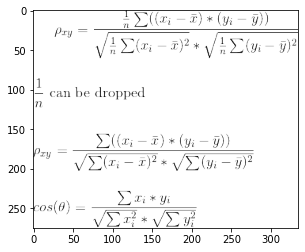

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('ka.gif')
plt.imshow(img)

## - les films sans note qui peuvent biaiser le calcul de la similarité

In [19]:
ratings['title'].value_counts()

Forrest Gump (1994)                      329
Shawshank Redemption, The (1994)         317
Pulp Fiction (1994)                      307
Silence of the Lambs, The (1991)         279
Matrix, The (1999)                       278
                                        ... 
We're Back! A Dinosaur's Story (1993)      1
American Hardcore (2006)                   1
Shanghai Surprise (1986)                   1
Let's Get Harry (1986)                     1
Andrew Dice Clay: Dice Rules (1991)        1
Name: title, Length: 9719, dtype: int64

In [14]:
ratings.shape

(100836, 5)

In [14]:
userRatings=ratings.pivot_table(index=['userId'],columns=['title'],values='rating')

userRatings.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
userRatings.shape

(610, 9719)

# - perte d'informations

In [29]:
a=userRatings.dropna(thresh=10, axis=1)
a.count()

title
'burbs, The (1989)                   17
(500) Days of Summer (2009)          42
10 Cloverfield Lane (2016)           14
10 Things I Hate About You (1999)    54
10,000 BC (2008)                     17
                                     ..
Zoolander (2001)                     54
Zootopia (2016)                      32
eXistenZ (1999)                      22
xXx (2002)                           24
¡Three Amigos! (1986)                26
Length: 2269, dtype: int64

In [21]:
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
a=userRatings
corrMatrix = userRatings.corr(method='pearson')
corrMatrix

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.063117,-0.023768,0.143482,0.011998,0.087931,0.224052,0.034223,0.009277,0.008331,...,0.017477,0.032470,0.134701,0.153158,0.101301,0.049897,0.003233,0.187953,0.062174,0.353194
(500) Days of Summer (2009),0.063117,1.000000,0.142471,0.273989,0.193960,0.148903,0.142141,0.159756,0.135486,0.200135,...,0.374515,0.178655,0.068407,0.414585,0.355723,0.252226,0.216007,0.053614,0.241092,0.125905
10 Cloverfield Lane (2016),-0.023768,0.142471,1.000000,-0.005799,0.112396,0.006139,-0.016835,0.031704,-0.024275,0.272943,...,0.242663,0.099059,-0.023477,0.272347,0.241751,0.195054,0.319371,0.177846,0.096638,0.002733
10 Things I Hate About You (1999),0.143482,0.273989,-0.005799,1.000000,0.244670,0.223481,0.211473,0.011784,0.091964,0.043383,...,0.243118,0.104858,0.132460,0.091853,0.158637,0.281934,0.050031,0.121029,0.130813,0.110612
"10,000 BC (2008)",0.011998,0.193960,0.112396,0.244670,1.000000,0.234459,0.119132,0.059187,-0.025882,0.089328,...,0.260261,0.087592,0.094913,0.184521,0.242299,0.240231,0.094773,0.088045,0.203002,0.083518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoolander (2001),0.049897,0.252226,0.195054,0.281934,0.240231,0.184324,0.274260,0.122107,0.017351,0.091416,...,0.304364,0.243820,-0.006269,0.242033,0.299522,1.000000,0.108147,0.097147,0.338034,0.109455
Zootopia (2016),0.003233,0.216007,0.319371,0.050031,0.094773,0.054024,0.077594,0.056742,0.063325,0.225747,...,0.286213,0.156603,0.011418,0.214385,0.298504,0.108147,1.000000,0.046885,0.200762,0.020595
eXistenZ (1999),0.187953,0.053614,0.177846,0.121029,0.088045,0.047804,0.085606,-0.001708,0.002528,0.128638,...,0.088202,0.028566,0.167541,0.145741,0.068763,0.097147,0.046885,1.000000,0.163022,0.138611


# Système de recommendation avec pyspark avec 100k votes

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from time import time
import numpy as np


spark = SparkSession.builder\
        .master("local[*]")\
        .appName("adult_data")\
        .getOrCreate()

In [2]:
from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()
#sqlContext=SQLContext(sc)

In [120]:
movies = spark.read.csv("test/movies.csv",header=True,inferSchema=True)
ratings = spark.read.csv("test/ratings.csv",header=True,inferSchema=True)

In [122]:
# Create test and train set
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)

# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [15, 16]) \
            .addGrid(als.regParam, [.1, .15, .16]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 

# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [125]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8703406401133936


In [126]:
test_predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   580|   1580|   4.0|1167792444| 3.4246755|
|   580|  44022|   3.5|1167792560|  3.252136|
|   597|    471|   2.0| 941558175| 3.9728734|
|   108|   1959|   5.0|1042840682|  3.724212|
|   368|   2122|   2.0| 971277319| 1.8176079|
|   436|    471|   3.0| 833530187|  3.529783|
|   587|   1580|   4.0| 953138475| 3.8569307|
|    27|   1580|   3.0| 962686758|  3.387348|
|   606|   1580|   2.5|1171310310| 3.1433513|
|   606|  44022|   4.0|1259446275| 2.8629034|
|    91|   2122|   4.0|1112717166| 2.3220754|
|   157|   3175|   2.0| 992479927|  3.340296|
|   232|   1580|   3.5|1218165957| 3.3654888|
|   232|  44022|   3.0|1182909752| 3.1511335|
|   246|   1645|   4.0|1354125095| 3.8866725|
|   599|   2366|   3.0|1519122035| 2.8605177|
|   111|   1088|   3.0|1516153967| 3.5352888|
|   111|   3175|   3.5|1518902708|  3.267802|
|    47|   1580|   1.5|1496209799|

In [127]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(5)
nrecommendations.limit(5).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{3379, 5.958359}...|
|     2|[{131724, 4.78669...|
|     3|[{6835, 4.8534336...|
|     4|[{3851, 4.8355303...|
|     5|[{3379, 4.69518},...|
+------+--------------------+



In [128]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import col
nrecommendations = nrecommendations.withColumn("rec_exp", explode("recommendations")).select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()


+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   3379| 5.958359|
|     1|   5490| 5.712782|
|     1|  33649|5.5336447|
|     1|  59018|5.5137987|
|     1|  60943|5.5137987|
|     2| 131724| 4.786693|
|     2|   3379|4.6902137|
|     2|  84273|4.4766545|
|     2| 117531|4.4766545|
|     2|   7071|4.4766545|
+------+-------+---------+



In [129]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).show(5)

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  67618|   100|5.4121814|Strictly Sexual (...|Comedy|Drama|Romance|
|   3379|   100|5.2710643| On the Beach (1959)|               Drama|
|  33649|   100|5.1874986|  Saving Face (2004)|Comedy|Drama|Romance|
|  42730|   100| 5.137251|   Glory Road (2006)|               Drama|
|  93988|   100| 5.059599|North & South (2004)|       Drama|Romance|
+-------+------+---------+--------------------+--------------------+



In [130]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(5).show()

+-------+------+------+----------+--------------------+--------------+
|movieId|userId|rating| timestamp|               title|        genres|
+-------+------+------+----------+--------------------+--------------+
|   1101|   100|   5.0|1100184137|      Top Gun (1986)|Action|Romance|
|   5620|   100|   5.0|1100186982|Sweet Home Alabam...|Comedy|Romance|
|   1958|   100|   5.0|1100186258|Terms of Endearme...|  Comedy|Drama|
|   2423|   100|   5.0|1100186118|Christmas Vacatio...|        Comedy|
|   4041|   100|   5.0|1100184235|Officer and a Gen...| Drama|Romance|
+-------+------+------+----------+--------------------+--------------+



# Passage à echelle de 100k votes à 15M de votes

In [3]:
movies = spark.read.csv("movies.csv",header=True,inferSchema=True)
ratings = spark.read.csv("ratings.csv",header=True,inferSchema=True)

In [4]:
# Create test and train set
#(train, test) = ratings.randomSplit([0.6, 0.4], seed = 1234)
#(train, test) = train.randomSplit([0.6, 0.4], seed = 1234)
model_data=ratings.sample(0.6,123)

In [5]:
# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [15, 16]) \
            .addGrid(als.regParam, [.1, .15, .16]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [8]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8237700922850492


In [9]:
test_predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|    31|   1580|   3.0|1256229363| 2.3581998|
|    76|   1342|   3.5|1191101927| 2.7589564|
|    76|   1959|   5.0|1346219995| 3.1461983|
|    76|   3175|   3.5|1285210835|  3.497293|
|   159|  54190|   5.0|1214776416|  3.771371|
|   243|  44022|   3.0|1464352266|  2.329501|
|   296|   1580|   3.0|1322228394| 2.6633997|
|   368|  54190|   4.0|1402801465|  3.391007|
|   375|   1580|   2.5|1284917376|  3.568307|
|   385|   1088|   3.0| 944904308|  2.780378|
|   472|   1088|   4.0| 985195810| 3.3597848|
|   501|   1645|   4.0|1090380127| 3.1731796|
|   596|   1580|   3.0|1284573991| 3.4964166|
|   597|   1645|   5.0| 997422816| 3.3225515|
|   597|   2142|   2.0| 997420310| 3.0871937|
|   597|   3175|   5.0|1081574993| 3.9455018|
|   606|   4519|   4.0|1496447193| 3.7341292|
|   606|  36525|   2.5|1521247022|  4.213597|
|   606|  68135|   3.5|1508016502|

In [10]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(5)
nrecommendations.limit(5).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    26|[{203086, 5.80058...|
|    27|[{203086, 6.09084...|
|    28|[{194434, 7.29912...|
|    31|[{158601, 3.99238...|
|    34|[{194434, 5.89356...|
+------+--------------------+



In [5]:
time_prediction=[]
# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [15, 16]) \
            .addGrid(als.regParam, [.15, .16]) \
            .build()
#.addGrid(als.maxIter, [5, 50, 100, 200]) \    
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
#Fit cross validator to the 'train' dataset
for i in np.arange(0.05,1.05,0.05):
    sample=model_data.sample(i,123)
    (trainingData, testData) = sample.randomSplit([0.7, 0.3])
    
    model = cv.fit(trainingData)
    #Extract best model from the cv model above
    best_model = model.bestModel
    t0 = time()
    test_predictions = best_model.transform(testData)
    tt = time() - t0
    time_prediction.append(tt)
    b=i*100
    print ("Classifier predict sample {}% in {} seconds".format(b,round(tt,3)))

Classifier predict sample 5.0% in 0.039 seconds
Classifier predict sample 10.0% in 0.026 seconds
Classifier predict sample 15.000000000000002% in 0.027 seconds
Classifier predict sample 20.0% in 0.019 seconds
Classifier predict sample 25.0% in 0.017 seconds
Classifier predict sample 30.0% in 0.027 seconds
Classifier predict sample 35.0% in 0.027 seconds
Classifier predict sample 40.0% in 0.015 seconds
Classifier predict sample 45.0% in 0.028 seconds
Classifier predict sample 50.0% in 0.022 seconds
Classifier predict sample 55.00000000000001% in 0.017 seconds
Classifier predict sample 60.00000000000001% in 0.022 seconds
Classifier predict sample 65.00000000000001% in 0.012 seconds
Classifier predict sample 70.0% in 0.032 seconds
Classifier predict sample 75.00000000000001% in 0.026 seconds
Classifier predict sample 80.0% in 0.021 seconds
Classifier predict sample 85.00000000000001% in 0.017 seconds
Classifier predict sample 90.00000000000001% in 0.026 seconds
Classifier predict sample 9

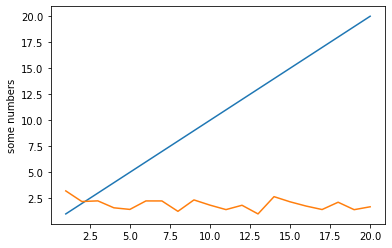

In [6]:
T=[]
S=np.array(time_prediction)
for i in np.arange(0.05,1.05,0.05):
    b=i/0.05
    T.append(b)
#S=np.array([34.505,33.306,35.846,35.708,38.136,37.237,43.079,40.751,43.77,41.608,45.652,43.326,46.551,46.081,48.126,48.684,50.077,49.924,51.885]) 
time_prediction=S/min(time_prediction)

import matplotlib.pyplot as plt
plt.plot(T,T)
plt.plot(T,time_prediction)
plt.ylabel('some numbers')
plt.show()